This Baseball project journey has led me to my destination; applying machine learning algorithms to predictive models.  It started out with selecting a topic which I did... baseball batting performance using OPS as the metric.  Next, data was acquired for the project from the Sean Lahman data set.  Special thanks to Sean for all the hard work!  Data was wrangled into model format for the project.  Data was validated against FanGraphs data using APIs and the pybaseball package.  After validation, exploratory data analysis (EDA) was performed on the data and statistical methods were applied to the information during that statistics part of the project.   

Which leads me to the most exciting part.  The machine learning part of the journey.  This part consisted of building a predictive model using Lahman data which was wrangled into a useable format of X and y where X is a panda dataframe of features and y is a panda series of metric OPS to be predicted.  The most difficult area of this part of the journey was the model design.  It took a few months to get it where I wanted it to be.  I started with features like age, height, weight and body mass which gave me very limited results.  Next, lag1 performance values like OPS, hits, home runs were added and the results got better but more work was needed.  After viewing one of the the Harvard University classes on regression towards the mean (rtm), additional research was done, and rtm was incorporated into the project.  See the final report on this project for the details of how that was done.

This program runs a series of regression machine learning algorithms using the predictive model for baseball player performance prediction.  The models used are from sklearn machine learning library and are

                       Non-Linear Regression
                       Ridge Regression
                       XGBoost
                       Random Forests 
                       SVR
                       Lasso for viewing features and redundencies

There are two parts to the program.  One is the execution of all six algorithms against the model in sequence.  The second part is a comparison of the regression to the mean (rtm) features and the non-rtm features to see if rtm made a postive difference.  Only XGBoost and Ridge Regression were used for this part of the excersize.  This Jupyter Notebook only runs teh sequence of the six algorithms.  See the final report on the results of the comparison of non-rtm and rtm runs.  The results showed that using rtm features resulted in better accuracy of the model.  All runs in this Jupyter Notebook uses the rtm features.

Let's get started.  The initial code starts with the imported libraries required for the project and functions required.
  

In [1]:
#
#  This program runs a set of machine learning algorithms using a batting performance model which 
#  predicts OPS performance for players for a future year.
#
import pandas as pd
import numpy as np
from datetime import datetime
import os.path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import pylab as plb
import matplotlib.mlab as mlab
import math
from numpy.random import seed
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from statsmodels.graphics.regressionplots import *
from scipy.stats import probplot
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
from IPython.core.pylabtools import figsize
import random
import warnings
warnings.filterwarnings("ignore")

figsize(14,10)
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style('white') 

# standard global constants
MIN_AT_BATS = 0
START_YEAR = 1960
END_YEAR = 2018
FSHZ = 17
START_DATE = datetime.strptime(str(START_YEAR)+'-01-01','%Y-%m-%d')
END_DATE = datetime.strptime(str(END_YEAR)+'-12-31','%Y-%m-%d')
LEGEND_PROPERTIES = {'weight':'bold'}

# general save file function
def save_stats_file(path, fn, df):
    stf = path + fn
    df.to_csv(stf, index=None, header=True)
    return True

# custom split into training and test sets where a player will belong to one and only one set (training or testing).
def split_players(df,pct):
    random.seed(63)
    players = np.array(df.playerID.drop_duplicates())
    plen = len(players)
    indlst = random.sample(range(0,plen), round(pct*plen))
    print('Number of Training Players ' + str(round(plen*(1-pct))))
    print('Number of Testing Players ' + str(round(plen*pct)))
    test_players = np.array(players[indlst])
    train_players = np.setdiff1d(players,test_players)
    return train_players, test_players

# custom split into training and test sets
def split_df(df,pct):
    train_p, test_p = split_players(df,pct)
    df_train = df[df.playerID.isin(train_p)]
    df_test = df[df.playerID.isin(test_p)]
    return df_train, df_test

# normalize numeric values if zeromean then use zero mean calc, otherwise use min/max calc
def normalize_values(X,cols,cn,type):
    if type == 'zeromean' :
        X[cn] = (X.loc[:,cols] - np.mean(X.loc[:,cols]))/ np.std(X.loc[:,cols])  
    else :
        X[cn] = (X.loc[:,cols] - np.min(X.loc[:,cols])) / ((np.max(X.loc[:,cols]))- np.min(X.loc[:,cols]))
    return X

# normalize categories (like Position)
def normalize_categories(X,cols,prefx):
    X_temp = X[cols]
    X = pd.get_dummies(X,columns=cols,prefix=prefx)
    X[cols] = X_temp
    return X

# custom calculation for R Squared, Adj R Squared, MSE, RMSE, FStatistic and others.  Same as what is supplied in python.
# I wanted to understand the calculations
def calc_regression_stats(X,y,yp):
    y = np.array(y)
    yp = np.array(yp)
    n = len(y)
    k = len(X.columns)
    yavg = sum(y)/n
    TSS = sum((y - yavg) ** 2)
    RSS = sum((y - yp) ** 2)
    Rsquared = 1 - (RSS/TSS)
    AdjRsquared = Rsquared - ((1-Rsquared) * ( k / ( n - k - 1 ) ) )
    MSE = RSS / n
    RMSE = np.sqrt(MSE)
    Fstatistic = ( Rsquared / (1 - Rsquared) ) * ( (n - k - 1 ) / k ) 
    error = ( (y - yp) / y ) * 100
    AbsErrorSum = sum(abs(error))
    MeanOfError = np.mean(error)
    StdOfError = np.std(error)
    return Rsquared, AdjRsquared, MSE, RMSE, Fstatistic, MeanOfError, StdOfError, AbsErrorSum

# various plots for assessing each machine learning run for each algorithm
def lr_results(df,X_test,y_test,y_pred,path,fn,stats_list,mdlinst):
    df_results = df.loc[y_test.index, :]
    df_results['predOPS'] = y_pred
    df_results['error'] = 100 * ( ( df_results['OPS'] - df_results['predOPS'] ) / df_results['OPS'])
    df_results['abserror'] = np.abs(100 * ( ( df_results['OPS'] - df_results['predOPS'] ) / df_results['OPS']))
    #
    df_results['predOPS'] = df_results['predOPS']
    df_results['OPS'] = df_results['OPS']
    df_results['error'] = df_results['error']
    df_out = df_results[stats_list]
    save_stats_file(path,fn, df_out)
    #  calculate Rsquared, Adj Rsquared, MSE, RMSE and Fstatistic using my routine
    Rsquared, AdjRsquared, MSE, RMSE, Fstatistic, MeanOfError, StdOfError, AbsErrorSum = calc_regression_stats(X_test,y_test,y_pred)
    # print statistics
    print('R Squared: %1.4f' % Rsquared)
    print('Adjusted R Squared: %1.4f' % AdjRsquared)
    print('F Statistic: %1.4f' % Fstatistic)
    print('MSE: %1.4f' % MSE)
    print('RMSE: %1.4f' % RMSE)
    print('Test Observations:',format(len(y_test)))
    print('Sum of Abs Pct Error: %5.1f' % AbsErrorSum)
    print('Pct Mean Error: %1.4f' % MeanOfError)
    print('Pct Std Dev Error: %1.4f' % StdOfError)
    # print plots
    fig, ax = plt.subplots()
    ax.grid()
    acc = df_results.error
    ptile = np.percentile(acc,[15,85,2.5,97.5])
    # actual vs. predicted OPS scatter plot
    sns.regplot(x=df_out['OPS'], y=df_out['predOPS'],
                line_kws={"color":"r","alpha":0.7,"lw":5},
                scatter_kws={"color":"b","s":8}
               )
    plt.title('Actual OPS vs. Predicted OPS',fontsize=16, weight='bold')
    plt.xlabel('Actual OPS',fontsize=14, weight='bold')
    plt.ylabel('Predicted OPS',fontsize=14, weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()
    # histogram % error plot
    fig, ax = plt.subplots()
    ax.grid()
    plt.hist(acc,bins=25)
    plt.title('Error : Actual OPS - Predicted OPS',weight='bold',fontsize=16)
    plt.xlabel('Error',fontsize=14, weight='bold')
    plt.ylabel('Frequency',fontsize=14, weight='bold')
    lab = 'Error Mean: %1.2f' % round(np.mean(df_out.error),2)
    lab1 = 'Conf Interval 15 ( %1.3f' % ptile[0] + ' )'
    lab2 = 'Conf Interval 85 ( %1.3f' % ptile[1] + ' )'
    lab3 = 'Conf Interval 2.5 ( %1.3f' % ptile[2] + ' )'
    lab4 = 'Conf Interval 97.5 ( %1.3f' % ptile[3] + ' )'
    plb.axvline(round(np.mean(df_out.error),2),label=lab, color='brown')
    plb.axvline(round(ptile[0],3), label=lab1, color='red')
    plb.axvline(round(ptile[1],3), label=lab2, color='red')
    plb.axvline(round(ptile[2],3), label=lab3, color='green')
    plb.axvline(round(ptile[3],3), label=lab4, color='green')
    leg=plt.legend(prop=dict(size=14))
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()
    # QQ plot for normalcy
    fig, ax = plt.subplots()
    ax.grid()
    # plot QQ Plot to see if normal
    probplot(acc,dist="norm",plot=plb)
    _ = plt.title('QQ Plot of OPS Error Data',weight='bold', size=16)
    _ = plt.ylabel('Ordered Values', labelpad=10, weight='bold',size=14)
    _ = plt.xlabel('Theoritical Quantiles', labelpad=10, weight='bold',size = 14)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
    plt.xticks(np.arange(-4,5,1))
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plb.show()
    # scatter plot of residuals vs. predicted OPS
    fig, ax = plt.subplots()
    ax.grid()
    plt.plot(y_pred, (y_pred-y_test), marker='.',linestyle='none',color='b')
    plt.title('Predicted OPS vs. Residuals',weight='bold', size=16)
    plt.xlabel('Predicted OPS',weight='bold', size=16)
    plt.ylabel('Residuals',weight='bold', size=16)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()
    return True


This next step is to read the saved dataframe in CSV format into the program.  We also add some addition columns to the dataframe model.  The models were run with a training  set and a testing set with 80% training and 20% testing.  A custom training / test split algorithm was used in favor of the standard train_test_split() function.  Given a player’s career, there should be no player that is split across the training / testing sets.  That is, given a player, all yearly career statistics for this player should either be in the training set or the test set but not both.  In this way, the training set does not see any years of a player who is being predicted in the testing set.   

In [55]:
# set path for reading Lahman baseball statistics and read data from rttm dataset
path = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\core\\'

battingf = path + 'dfbatting_player_stats_rttm_OPS.csv'
dfbatting_player_stats = pd.read_csv(battingf,parse_dates=['debut','finalGame','birthdate'])

dfbatting_player_stats = dfbatting_player_stats[(dfbatting_player_stats['debut'] >= START_DATE) &
                                                (dfbatting_player_stats['finalGame'] <= END_DATE)]
df = dfbatting_player_stats
df = df.reset_index(drop=True)
df = df[df['AB'] >= 300]
print(df.head(10))

# add decade
df['decade'] = (df['yearID'] // 10)*10

# normalize feature data
df = normalize_categories(df,['POS'],['POS']) 
df = normalize_values(df,['years_played','lag1_rtm_cAVG',  'lag1_rtm_AVG',  'lag1_cAVG',  'lag1_AVG', 'lag1_HR', 'lag1_cHR', 'lag1_rtm_HR', 'lag1_rtm_cHR', 'lag1_H', 'lag1_rtm_H', 'lag1_cH', 'lag1_rtm_cH', 'lag1_TB',  'lag1_cTB',  'lag1_AB',  'lag1_cAB', 'lag1_rtm_SLGTB', 'lag1_rtm_cSLGTB',  'lag1_rtm_SLGAB',  'lag1_rtm_cSLGAB', 'lag1_rtm_AB', 'lag1_rtm_cAB', 'decade',  'lag1_OPS', 'lag1_cOPS', 'lag1_OB', 'lag1_PA', 'lag1_OBP', 'lag1_cOBP', 'lag1_SLG', 'lag1_cSLG' ,'lag1_cOB',  'lag1_cPA', 'lag1_rtm_OB', 'lag1_rtm_PA', 'lag1_rtm_OPS', 'lag1_rtm_cOB', 'lag1_rtm_cPA', 'lag1_rtm_cOPS',  'age', 'height', 'weight', 'lag1_rtm_c1B', 'lag1_rtm_c2B', 'lag1_rtm_c3B', 'lag1_rtm_1B', 'lag1_rtm_2B', 'lag1_rtm_3B', 'lag1_c1B', 'lag1_c2B', 'lag1_c3B', 'lag1_1B', 'lag1_2B', 'lag1_3B', 'lag1_rtm_OBP', 'lag1_rtm_cOBP', 'lag1_rtm_SLG',  'lag1_rtm_cSLG'],
                         ['nyears_played','lag1_rtm_ncAVG', 'lag1_rtm_nAVG', 'lag1_ncAVG', 'lag1_nAVG','lag1_nHR','lag1_ncHR','lag1_rtm_nHR','lag1_rtm_ncHR','lag1_nH','lag1_rtm_nH','lag1_ncH','lag1_rtm_ncH','lag1_nTB', 'lag1_ncTB', 'lag1_nAB', 'lag1_ncAB','lag1_rtm_nSLGTB','lag1_rtm_ncSLGTB', 'lag1_rtm_nSLGAB', 'lag1_rtm_ncSLGAB','lag1_rtm_nAB','lag1_rtm_ncAB','ndecade', 'lag1_nOPS','lag1_ncOPS','lag1_nOB','lag1_nPA','lag1_nOBP','lag1_ncOBP','lag1_nSLG','lag1_ncSLG','lag1_ncOB', 'lag1_ncPA','lag1_rtm_nOB','lag1_rtm_nPA','lag1_rtm_nOPS','lag1_rtm_ncOB','lag1_rtm_ncPA','lag1_rtm_ncOPS', 'nage','nheight','nweight','lag1_rtm_nc1B','lag1_rtm_nc2B','lag1_rtm_nc3B','lag1_rtm_n1B','lag1_rtm_n2B','lag1_rtm_n3B','lag1_nc1B','lag1_nc2B','lag1_nc3B','lag1_n1B','lag1_n2B','lag1_n3B','lag1_rtm_nOBP','lag1_rtm_ncOBP','lag1_rtm_nSLG', 'lag1_rtm_ncSLG'],'zeromean')

# read team mapping and create a mapping function from string to integer
teamsf = path + 'teams_list.csv'
dfteams = pd.read_csv(teamsf)
teams_map = pd.Series(dfteams.index,index=dfteams.teamID).to_dict()
df.teamID = df.teamID.map(teams_map)


   yearID   playerID    G   AB    H  2B  3B  HR  SF   BB  ...  lag1_cAVG  \
0    1995  abbotku01  120  420  107  18   7  17   5   36  ...   0.249275   
1    1996  abbotku01  109  320   81  18   7   8   0   22  ...   0.252288   
2    2002  abernbr01  117  463  112  18   4   2   2   25  ...   0.269737   
3    1999  abreubo01  152  546  183  35  11  20   4  109  ...   0.311871   
4    2000  abreubo01  154  576  182  42  10  25   3  100  ...   0.324065   
5    2001  abreubo01  162  588  170  48   4  31   9  106  ...   0.321186   
6    2002  abreubo01  157  572  176  50   6  20   6  104  ...   0.312642   
7    2003  abreubo01  158  577  173  35   1  20   7  109  ...   0.311623   
8    2004  abreubo01  159  574  173  47   1  30   7  127  ...   0.309595   
9    2005  abreubo01  162  588  168  37   1  24   8  117  ...   0.308397   

    cOB   cPA      cOBP    cH   cAB  cHR   cTB      cSLG      cOPS  
0   255   834  0.305755   193   765   26   326  0.426144  0.731899  
1   361  1179  0.306192  

The next step is to run the first algorithm (Lasso Regression).  We are only interested in the dimensionality and reduction of dimensions of the model.  Note that there are some additional filters on the testing set.  Analysis was performed and outlier data was eliminated from the testing set. In addition to the rtm features run against the Lasso algorithm, the non-rtm features were run as well for comparison purposes.

Analysis showed that a .300 OPS or less and an OPS of 1.2 or greater fell outside the 2.5 and 97.5 percentiles.  In addition, analysis showed that player ages less than 20 and older than 37 fell outside the 2.5 and 97.5 percentiles.

Number of Training Players 1361
Number of Testing Players 340
Number of Training Records: 7771
Number of Testing Records: 1919


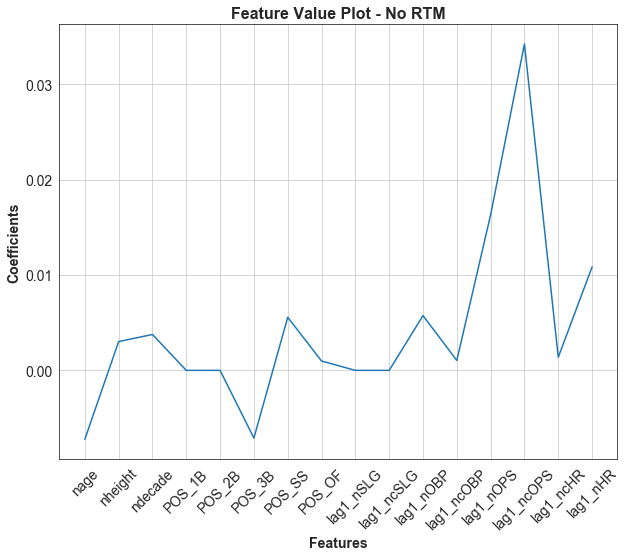

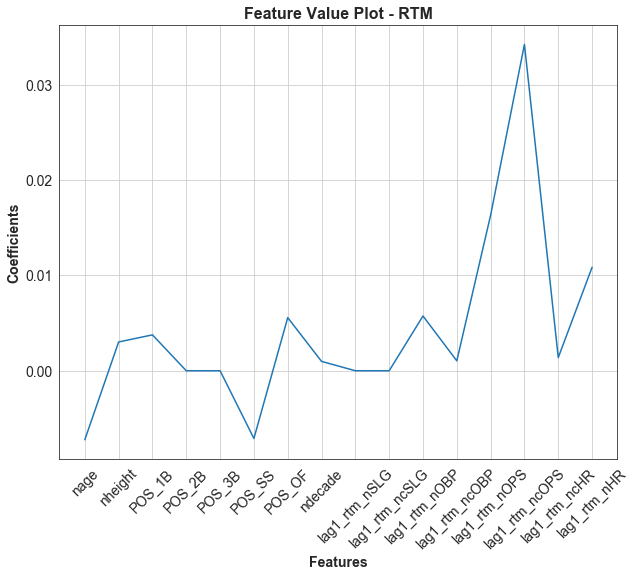

In [56]:
figsize(10,8)

pct = 0.20

# custom train / test split on player boundaries.  IE, a player will belong to one and only one set (training or test)
# for a given run
df_train, df_test = split_df(df,pct)

print('Number of Training Records:',len(df_train))
df_test = df_test[ (df_test['OPS'] > .3) & (df_test['OPS'] < 1.2) & (df['AB'] >= 300) & (df['age'] >= 20) & (df['age'] <= 37)  ]
print('Number of Testing Records:',len(df_test))
# list of columns to output to file once run is completed.    
stats_list = ['yearID','playername','OPS','predOPS','error','AB','H','AVG','HR','3B','2B','1B','POS','age','height','lag1_rtm_OPS']
feature_list = ['nage','nheight','ndecade','POS_1B','POS_2B','POS_3B','POS_SS','POS_OF','lag1_nSLG','lag1_ncSLG','lag1_nOBP','lag1_ncOBP','lag1_nOPS','lag1_ncOPS','lag1_ncHR','lag1_nHR',]
feature_list_rtm = ['nage','nheight','POS_1B','POS_2B','POS_3B','POS_SS','POS_OF','ndecade','lag1_rtm_nSLG','lag1_rtm_ncSLG','lag1_rtm_nOBP','lag1_rtm_ncOBP','lag1_rtm_nOPS','lag1_rtm_ncOPS','lag1_rtm_ncHR','lag1_rtm_nHR']
#
#  just want features and which ones provide value - non rtm
#
X_train = df_train[feature_list_rtm]
y_train = df_train.OPS
X_test = df_test[feature_list_rtm]
y_test = df_test.OPS  
lasso = Lasso(alpha=0.001, random_state=61)    
lasso_coef = lasso.fit(X_train, y_train).coef_    
cols = feature_list
fig, ax = plt.subplots()
ax.grid()
plt.plot(range(len(cols)), lasso_coef)
plt.xticks(range(len(cols)), cols, rotation=45)
plt.title('Feature Value Plot - No RTM',weight='bold', size=16 )
plt.xlabel('Features',weight='bold', size=14)
plt.ylabel('Coefficients',weight='bold', size=14)
for tick in ax.get_xticklabels():
    tick.set_fontsize(14)
for tick in ax.get_yticklabels():
    tick.set_fontsize(14)
plt.show()
#
#  just want features and which ones provide value - rtm
#
# setup model features X and prediction variable y.
X_train = df_train[feature_list_rtm]
y_train = df_train.OPS
X_test = df_test[feature_list_rtm]
y_test = df_test.OPS  
lasso = Lasso(alpha=0.001, random_state=61)    
lasso_coef = lasso.fit(X_train, y_train).coef_    
cols = feature_list_rtm
fig, ax = plt.subplots()
ax.grid()
plt.plot(range(len(cols)), lasso_coef)
plt.xticks(range(len(cols)), cols, rotation=45)
plt.title('Feature Value Plot - RTM',weight='bold', size=16 )
plt.xlabel('Features',weight='bold', size=14)
plt.ylabel('Coefficients',weight='bold', size=14)
for tick in ax.get_xticklabels():
    tick.set_fontsize(14)
for tick in ax.get_yticklabels():
    tick.set_fontsize(14)
plt.show()


Note that the two charts are very much different.  The rtm features rely heavily on the two normalized OPS features where the non-rtm relies on all of the features more heavily.

The next algorithm to run is XGBoost along with metrics and charts showing the results of the run.  GridSearchCV was also used to find the optimal parameters.  Some have already been identified.



XGBoost Regressor


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   37.8s finished




Training Statistics: 


R Squared (training): 0.498
Adjusted R Squared (training): 0.497
Mean Squared Error (training): 0.005
Root Mean Squared Error (training): 0.073
F Statistic (training): 481.611




Testing Statistics: 


R Squared: 0.4970
Adjusted R Squared: 0.4927
F Statistic: 117.4472
MSE: 0.0054
RMSE: 0.0733
Test Observations: 1919
Sum of Abs Pct Error: 14602.9
Pct Mean Error: -0.8717
Pct Std Dev Error: 9.6990


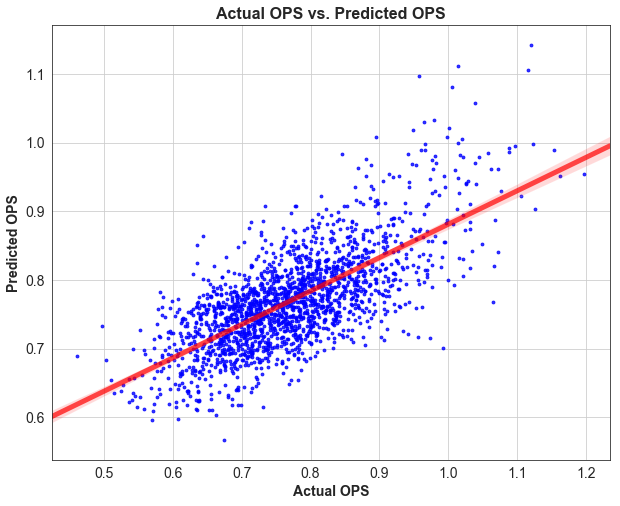

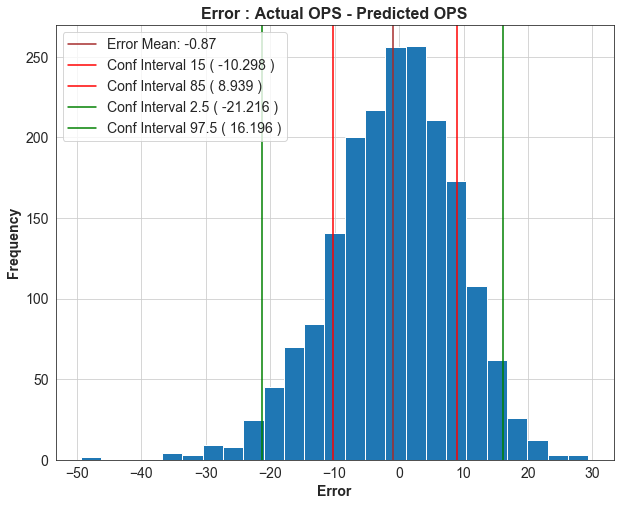

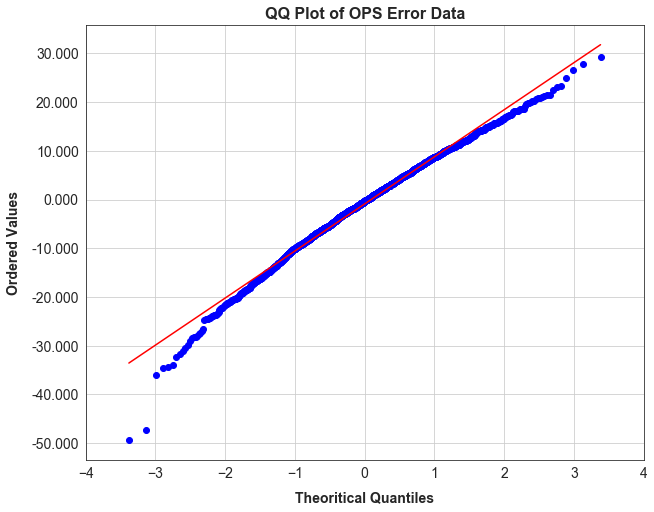

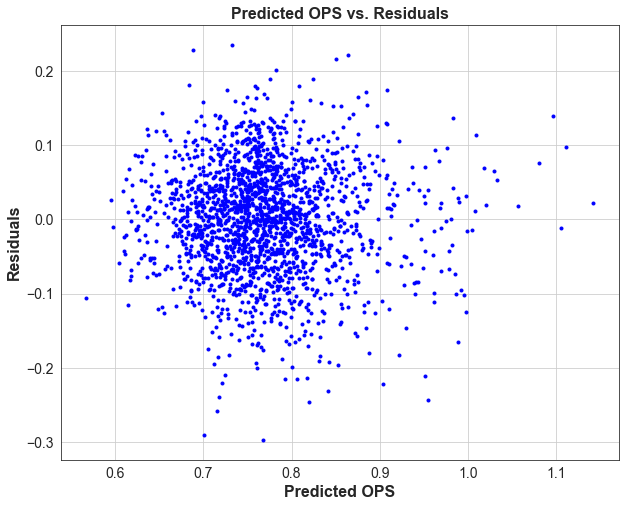

{'alpha': 0.01, 'colsample_bytree': 0.6, 'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 120, 'subsamples': 0.6}


In [57]:
print('\n')
print('XGBoost Regressor')
print('\n')
params = {
            'colsample_bytree': [0.6],
            'learning_rate':[0.1],
            'n_estimators': [100,120],
            'max_depth':[3,4],
            'alpha':[0.01],
            'gamma':[0.001],
            'subsamples':[0.6]
        }
reg_xgb = XGBRegressor(objective = 'reg:squarederror')    
gs = GridSearchCV(estimator=reg_xgb,param_grid=params,cv=10,n_jobs = -1,verbose = 2)    
gs.fit(X_train, y_train)    
y_pred2 = gs.predict(X_train)   
v_Rsquared, v_AdjRsquared, v_MSE, v_RMSE, v_Fstatistic, v_MeanOfError, v_StdOfError, v_AbsErrorSum = calc_regression_stats(X_train,y_train,y_pred2)    
print('\n')
print('Training Statistics: ')
print('\n')
print('R Squared (training): %1.3f' % v_Rsquared) 
print('Adjusted R Squared (training): %1.3f'  % v_AdjRsquared) 
print('Mean Squared Error (training): %1.3f' % v_MSE)
print('Root Mean Squared Error (training): %1.3f' % v_RMSE)
print('F Statistic (training): %1.3f' % v_Fstatistic)
print('\n')

print('\n')
print('Testing Statistics: ')
print('\n')
y_pred = gs.predict(X_test)
lr_results(df,X_test,y_test,y_pred,path,'OPSpredictionsXGB_GS.csv',stats_list,gs) 
print(gs.best_params_)

As you can see above, there are four plots: predicted OPS vs. actual OPS, an error histogram plot, a QQ plot for fit to normal dist.  and a residual vs. predicted OPS plot.  In addition metrics for training set and testing set are provided.

The next algorthm is Ridge Regression with statisics and plots.



Linear Regression - Ridge


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  40 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.0s finished




Training Statistics: 


R Squared (training): 0.417
Adjusted R Squared (training): 0.416
Mean Squared Error (training): 0.006
Root Mean Squared Error (training): 0.078
F Statistic (training): 347.213




Testing Statistics: 


R Squared: 0.4783
Adjusted R Squared: 0.4739
F Statistic: 108.9802
MSE: 0.0056
RMSE: 0.0747
Test Observations: 1919
Sum of Abs Pct Error: 14744.5
Pct Mean Error: -0.6406
Pct Std Dev Error: 9.8211


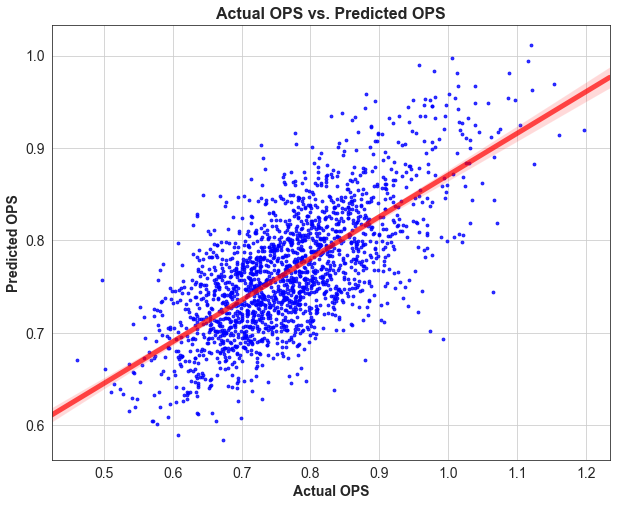

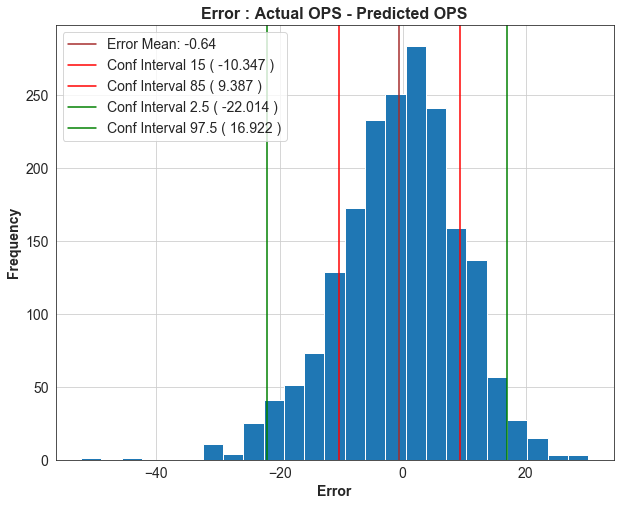

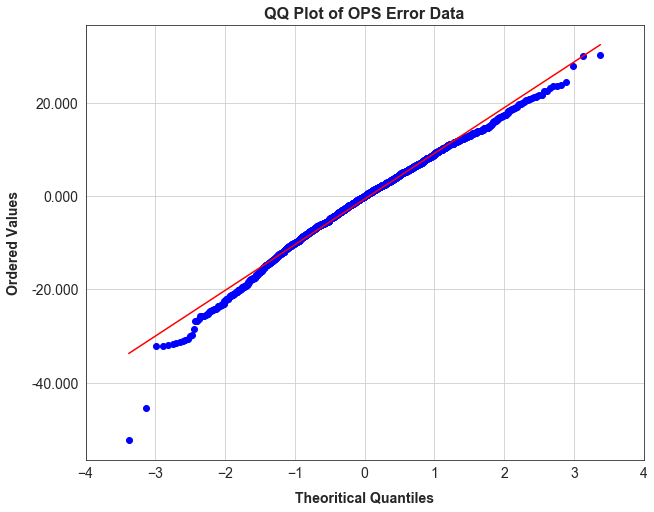

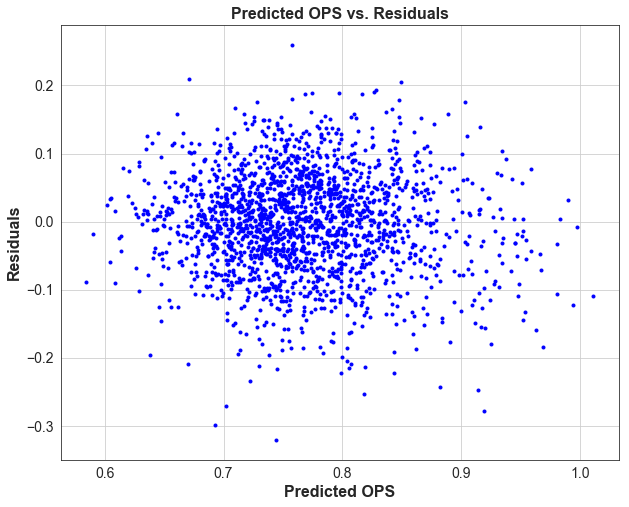

{'alpha': 0.1}


In [58]:
print('\n')
print('Linear Regression - Ridge')
print('\n')
params = {
            'alpha':[0.0001,0.001,0.1,0.1]
        }
ridge = Ridge(normalize=True,random_state=61)
gs = GridSearchCV(estimator=ridge,param_grid=params,cv=10,n_jobs = -1,verbose = 2)
gs.fit(X_train, y_train)    
y_pred2 = gs.predict(X_train)   
v_Rsquared, v_AdjRsquared, v_MSE, v_RMSE, v_Fstatistic, v_MeanOfError, v_StdOfError, v_AbsErrorSum = calc_regression_stats(X_train,y_train,y_pred2)    
print('\n')
print('Training Statistics: ')
print('\n')
print('R Squared (training): %1.3f' % v_Rsquared) 
print('Adjusted R Squared (training): %1.3f'  % v_AdjRsquared) 
print('Mean Squared Error (training): %1.3f' % v_MSE)
print('Root Mean Squared Error (training): %1.3f' % v_RMSE)
print('F Statistic (training): %1.3f' % v_Fstatistic)
print('\n')

print('\n')
print('Testing Statistics: ')
print('\n')
y_pred = gs.predict(X_test)   
lr_results(df,X_test,y_test,y_pred,path,'OPSpredictionsRidge.csv',stats_list,ridge)
print(gs.best_params_)

The next algorithm is Random Forest Regressor with stats and plots.



Random Forest Regressor


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.4min finished




Training Statistics: 


R Squared (training): 0.673
Adjusted R Squared (training): 0.672
Mean Squared Error (training): 0.003
Root Mean Squared Error (training): 0.059
F Statistic (training): 996.691




Testing Statistics: 


R Squared: 0.4802
Adjusted R Squared: 0.4758
F Statistic: 109.8143
MSE: 0.0056
RMSE: 0.0745
Test Observations: 1919
Sum of Abs Pct Error: 14823.7
Pct Mean Error: -0.7536
Pct Std Dev Error: 9.8485


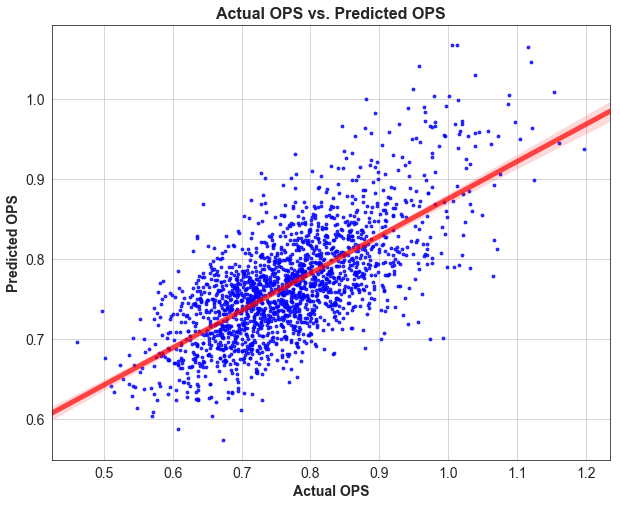

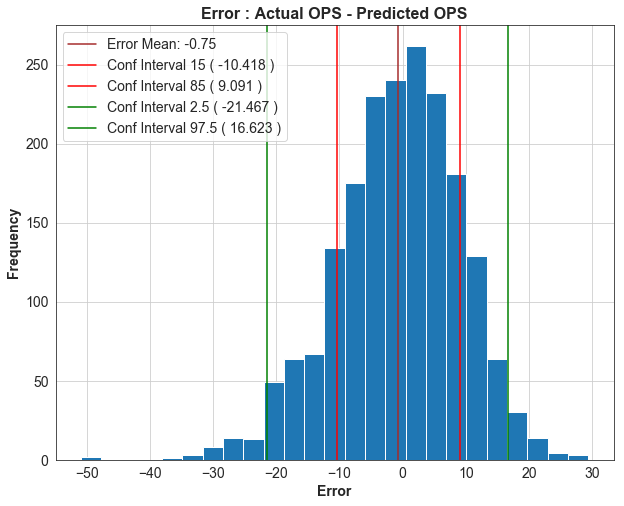

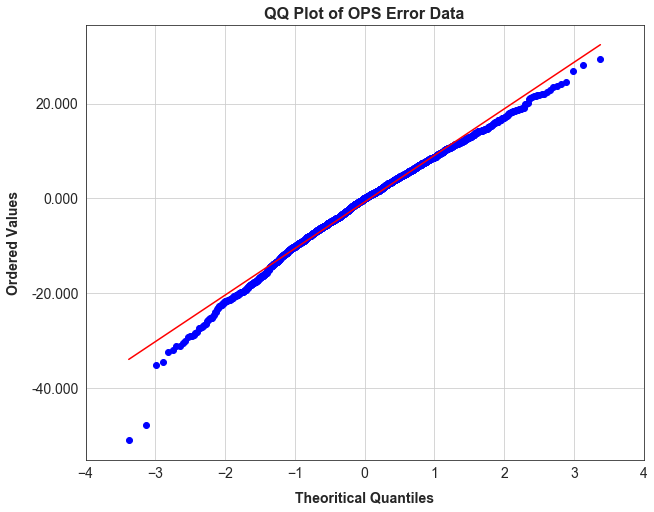

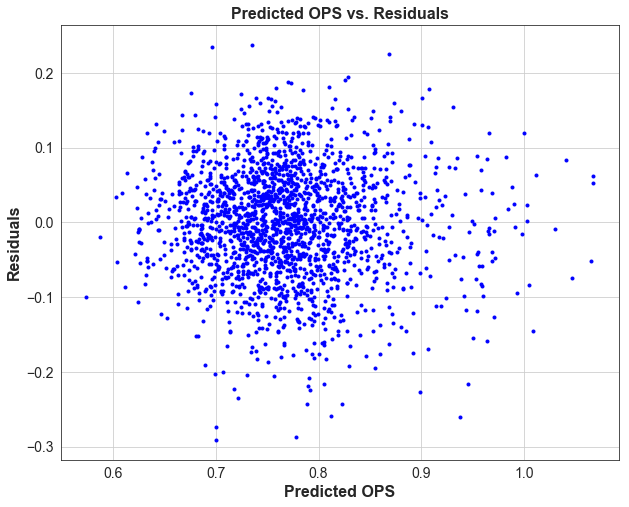

{'max_depth': 300, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 1500}


In [59]:
print('\n')
print('Random Forest Regressor')
print('\n')
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [300],
    'max_features': [3],
    'min_samples_leaf': [5],
    'min_samples_split': [12],
    'n_estimators': [1500]
}
# Create a based model
rf = RandomForestRegressor(random_state=61,bootstrap=True)
# Instantiate the grid search model
gs = GridSearchCV(estimator=rf,param_grid=params,cv=10,n_jobs = -1,verbose = 2)
gs.fit(X_train, y_train)    
y_pred2 = gs.predict(X_train)   
v_Rsquared, v_AdjRsquared, v_MSE, v_RMSE, v_Fstatistic, v_MeanOfError, v_StdOfError, v_AbsErrorSum = calc_regression_stats(X_train,y_train,y_pred2)    
print('\n')
print('Training Statistics: ')
print('\n')
print('R Squared (training): %1.3f' % v_Rsquared) 
print('Adjusted R Squared (training): %1.3f'  % v_AdjRsquared) 
print('Mean Squared Error (training): %1.3f' % v_MSE)
print('Root Mean Squared Error (training): %1.3f' % v_RMSE)
print('F Statistic (training): %1.3f' % v_Fstatistic)
print('\n')

print('\n')
print('Testing Statistics: ')
print('\n')
y_pred = gs.predict(X_test)  

lr_results(df,X_test,y_test,y_pred,path,'OPSpredictionsRF.csv',stats_list,gs)

print(gs.best_params_)   

The next run is Support Vector Regression (SVR)



Support Vector Regression


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   45.3s finished




Training Statistics: 


R Squared (training): 0.450
Adjusted R Squared (training): 0.449
Mean Squared Error (training): 0.006
Root Mean Squared Error (training): 0.076
F Statistic (training): 396.772




Testing Statistics: 


R Squared: 0.4963
Adjusted R Squared: 0.4921
F Statistic: 117.1289
MSE: 0.0054
RMSE: 0.0734
Test Observations: 1919
Sum of Abs Pct Error: 14594.6
Pct Mean Error: -1.0093
Pct Std Dev Error: 9.7215


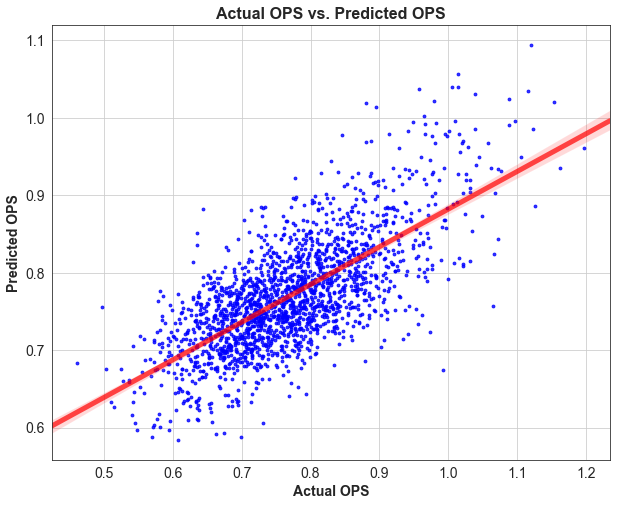

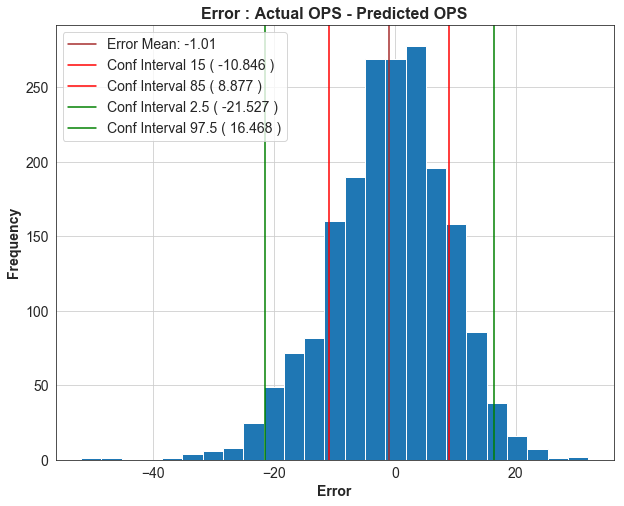

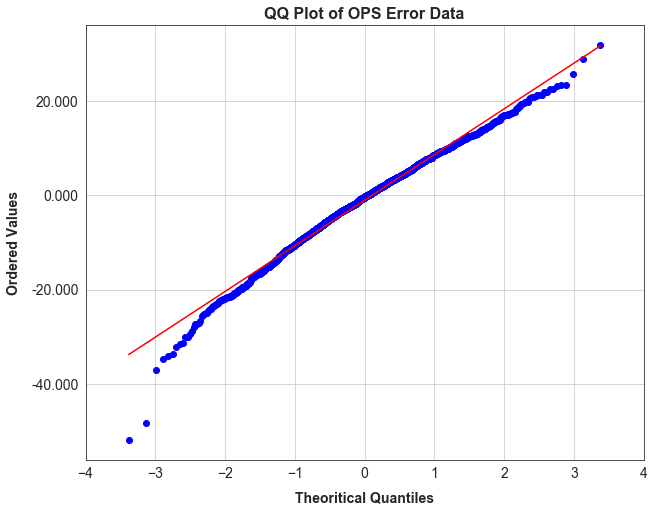

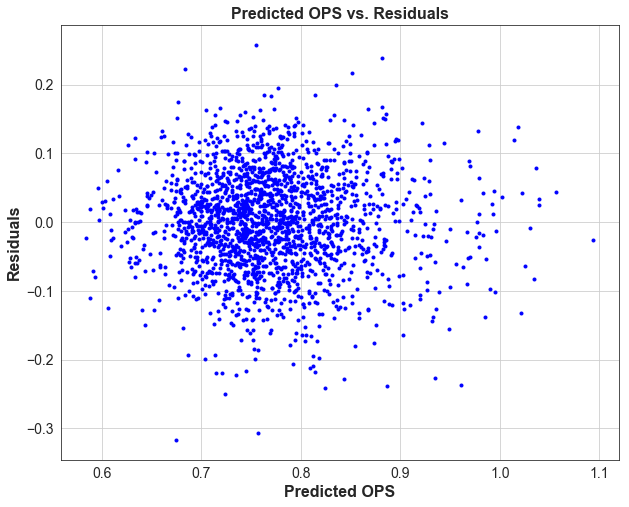

{'C': 1, 'gamma': 0.01}


In [60]:
print('\n')
print('Support Vector Regression')
print('\n')
params = {
    'C': [0.1,1],
    'gamma': [0.001, 0.01, 0.1]
}

svm = SVR(kernel='rbf')

gs = GridSearchCV(estimator=svm,param_grid=params,cv=10,n_jobs = -1,verbose = 2)
gs.fit(X_train, y_train)    
y_pred2 = gs.predict(X_train)   
v_Rsquared, v_AdjRsquared, v_MSE, v_RMSE, v_Fstatistic, v_MeanOfError, v_StdOfError, v_AbsErrorSum = calc_regression_stats(X_train,y_train,y_pred2)    
print('\n')
print('Training Statistics: ')
print('\n')
print('R Squared (training): %1.3f' % v_Rsquared) 
print('Adjusted R Squared (training): %1.3f'  % v_AdjRsquared) 
print('Mean Squared Error (training): %1.3f' % v_MSE)
print('Root Mean Squared Error (training): %1.3f' % v_RMSE)
print('F Statistic (training): %1.3f' % v_Fstatistic)
print('\n')

print('\n')
print('Testing Statistics: ')
print('\n')
y_pred = gs.predict(X_test)

lr_results(df,X_test,y_test,y_pred,path,'OPSpredictionsSVM_GS.csv',stats_list,gs)

print(gs.best_params_)

The last algorithm to run against the model is Non-Linear Regression.



Non-Linear Regression


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.0s finished


R Squared: 0.4919
Adjusted R Squared: 0.4876
F Statistic: 115.0862
MSE: 0.0054
RMSE: 0.0737
Test Observations: 1919
Sum of Abs Pct Error: 14650.2
Pct Mean Error: -1.1227
Pct Std Dev Error: 9.7446


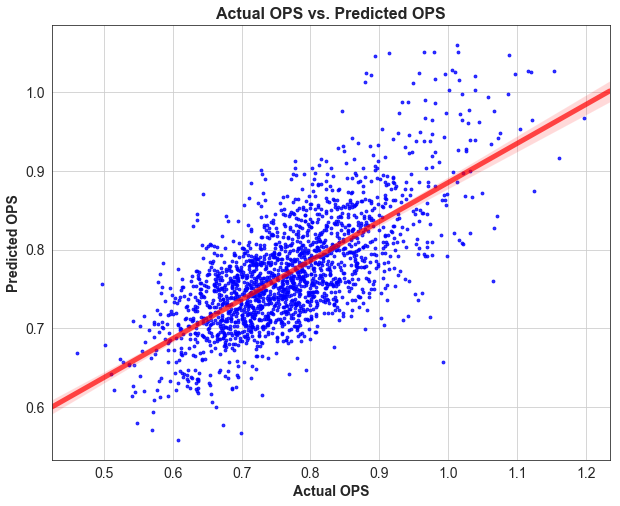

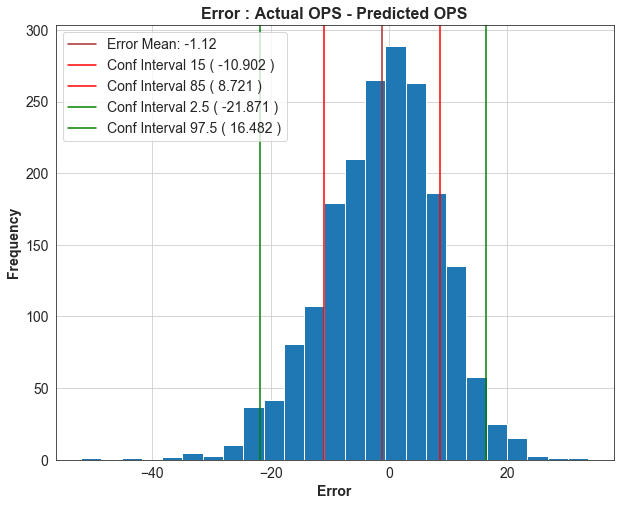

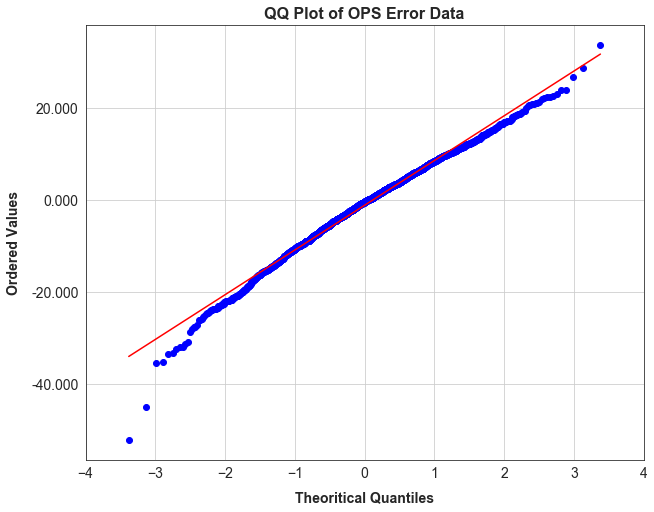

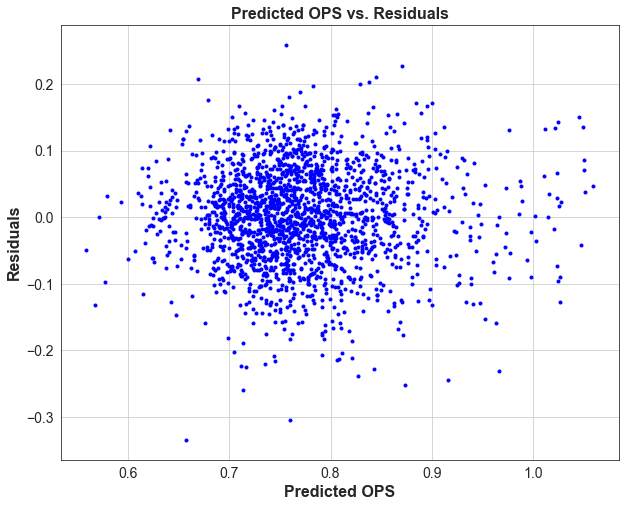

{'normalize': False}


In [61]:
print('\n')
print('Non-Linear Regression')
print('\n')

degree = 2

poly = PolynomialFeatures(degree=degree)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

lg = LinearRegression()

params = {
            'normalize':[True,False]
         }

gs = GridSearchCV(estimator=lg,param_grid=params,cv=10,n_jobs = -1,verbose = 2)

gs.fit(X_train_,y_train) 

y_pred = gs.predict(X_test_)

lr_results(df,X_test,y_test,y_pred,path,'OPSpredictionsPoly.csv',stats_list,gs)

print(gs.best_params_)

In conclusion, all of the machine learning algorthms performed well against the model.  Here is a summary of the results      (R Squared results):

                               XGBoost                 .4970
                               SVR                     .4967
                               Non Linear Regression   .4914
                               Random Forests          .4802
                               Ridge                   .4783


Each run outputs the OPS and predicted OPS values for each player as well as additional information such as playerID, player name and year played as well as other attributes.  The next step is to plot the mean values by age of OPS and predicted OPS.

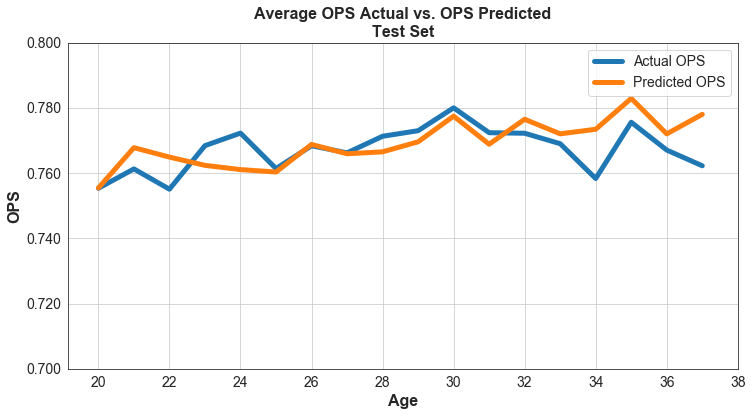

In [62]:
#
# this program plots the average actual OPS vs. average predicted OPS
#
import pandas as pd
import numpy as np
from datetime import datetime
import os.path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import pylab as plb
import matplotlib.mlab as mlab
from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings("ignore")

figsize(12,6)

path = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\core\\'
filen = 'OPSpredictionsXGB_GS.csv'
selectf = path + filen
df = pd.read_csv(selectf)
dfx = df.copy()
dfx = df[['age','OPS','predOPS']]
dfavg = df.groupby('age').mean()
dfavg = dfavg.reset_index(drop=False)

fig, ax = plt.subplots()
ax.grid()
plt.title('Average OPS Actual vs. OPS Predicted\nTest Set',weight='bold',size=16)
plt.xlabel('Age',weight='bold',size=16)
plt.ylabel('OPS',weight='bold',size=16)
plt.plot(dfavg.age,dfavg.OPS,label='Actual OPS',linewidth=5)
plt.plot(dfavg.age,dfavg.predOPS,label='Predicted OPS',linewidth=5)
plt.yticks(np.arange(.700,.800,.020))
plt.xticks(np.arange(20,39,2))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
leg = plt.legend(prop=dict(size=14))
plt.show()


As you can see from the chart above, the average predictions are very good.  Now, let's take a look at the top five players who had lucrative contracts in the major leagues (Albert Pujols, Alex Rodriguez, Derek Jeter, Joey Votto and Prince Fielder).

Player Name: Prince Fielder
Avg Actual OPS 0.887
Avg Predicted OPS 0.885
Pct Error 0.2


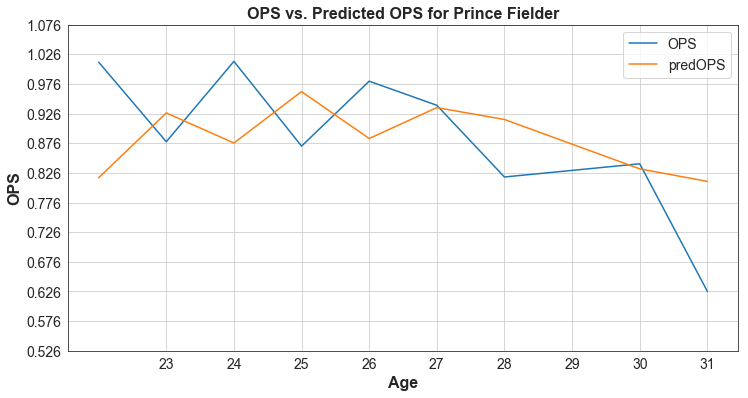

Player Name: Derek Jeter
Avg Actual OPS 0.832
Avg Predicted OPS 0.811
Pct Error 2.4


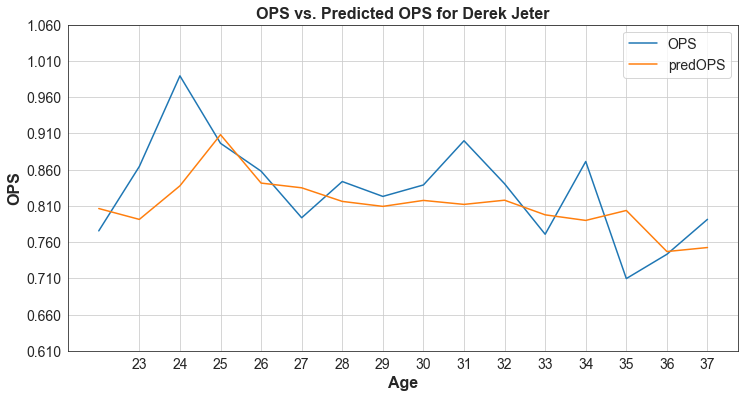

Player Name: Albert Pujols
Avg Actual OPS 0.927
Avg Predicted OPS 0.921
Pct Error 0.6


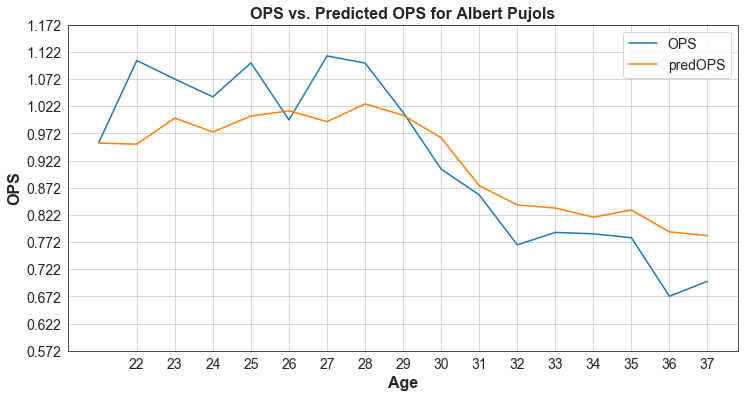

Player Name: Alex Rodriguez
Avg Actual OPS 0.939
Avg Predicted OPS 0.917
Pct Error 2.3


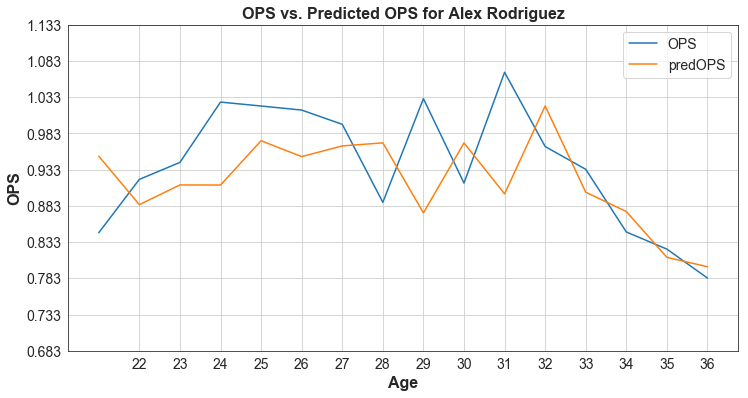

Player Name: Joey Votto
Avg Actual OPS 0.975
Avg Predicted OPS 0.921
Pct Error 5.5


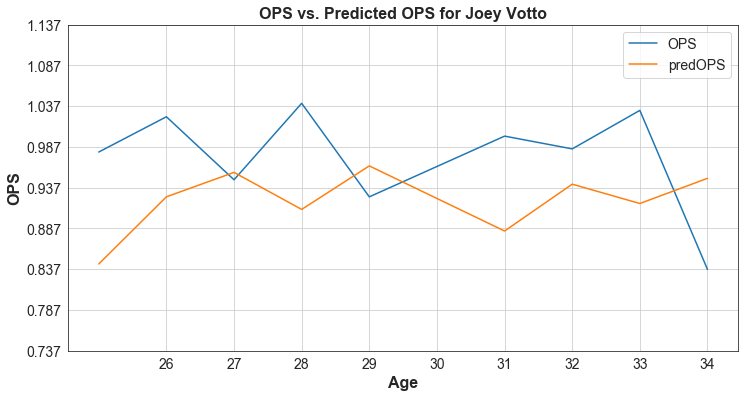

In [63]:
#
# plots actual OPS vs predicted OPS for the top five big contracts players received
#
path = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\core\\'
filen = 'OPSpredictionsXGB_GS_select.csv'
selectf = path + filen
dfs = pd.read_csv(selectf)
playerlst = ['pujolal01','rodrial01','jeterde01','vottojo01','fieldpr01']
dfsc = dfs[dfs['playerID'].isin(playerlst)]
plrlst = dfsc.playerID.drop_duplicates()
for p in plrlst:
    dfsp = dfs[dfs['playerID'] == p].sort_values('age')
    dfsp = dfsp.reset_index(drop=True)
    OPSlst = dfsp.OPS
    predOPSlst = dfsp.predOPS
    combOPS = OPSlst.append(predOPSlst)
    minOPS = round(min(combOPS),3)
    maxOPS = round(max(combOPS),3)
    agelst = dfsp.age
    minage = min(agelst)
    maxage = max(agelst)
    x = OPSlst.mean()
    y = predOPSlst.mean()
    z = ((x-y)/x ) * 100
    pname = dfsp.playername.drop_duplicates()[0]
    print('Player Name: ' + pname)
    print('Avg Actual OPS %1.3f' % x)
    print('Avg Predicted OPS %1.3f' % y)
    print('Pct Error %1.1f' % z)
    ttl = 'OPS vs. Predicted OPS for ' + pname
    fig, ax = plt.subplots()
    ax.grid()
    plt.title(ttl,weight='bold',size=16)
    plt.xlabel('Age',weight='bold',size=16)
    plt.ylabel('OPS',weight='bold',size=16)
    plt.plot(agelst, OPSlst)
    plt.plot(agelst, predOPSlst)
    plt.yticks(np.arange(minOPS-.1,maxOPS+.1,.050))
    plt.xticks(np.arange(minage+1,maxage+1,1))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    leg = plt.legend(prop=dict(size=14))
    plt.show()

Finally, I chart some of my favorite players.

Player Name: Lou Brock
Avg Actual OPS 0.760
Avg Predicted OPS 0.747
Pct Error 1.7


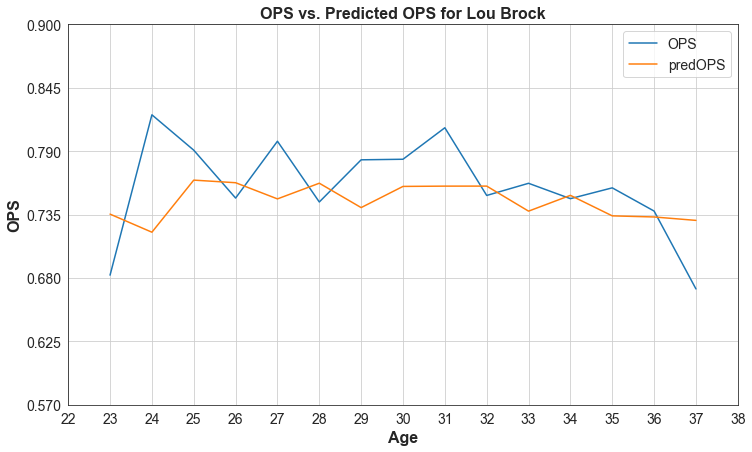

Player Name: Royce Clayton
Avg Actual OPS 0.684
Avg Predicted OPS 0.687
Pct Error -0.4


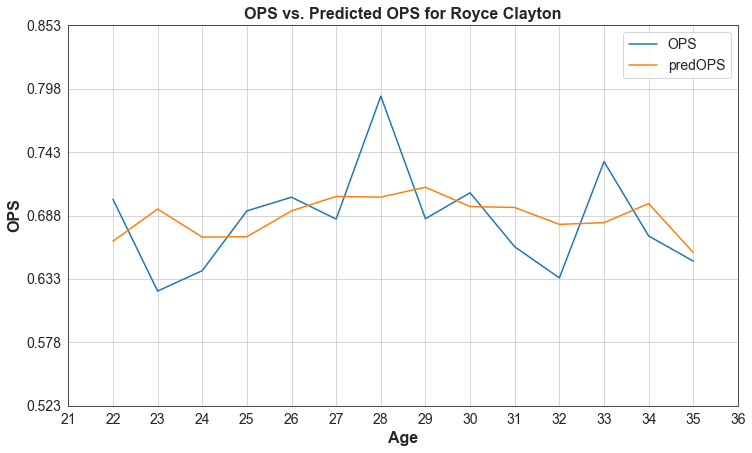

Player Name: Paul Goldschmidt
Avg Actual OPS 0.947
Avg Predicted OPS 0.886
Pct Error 6.5


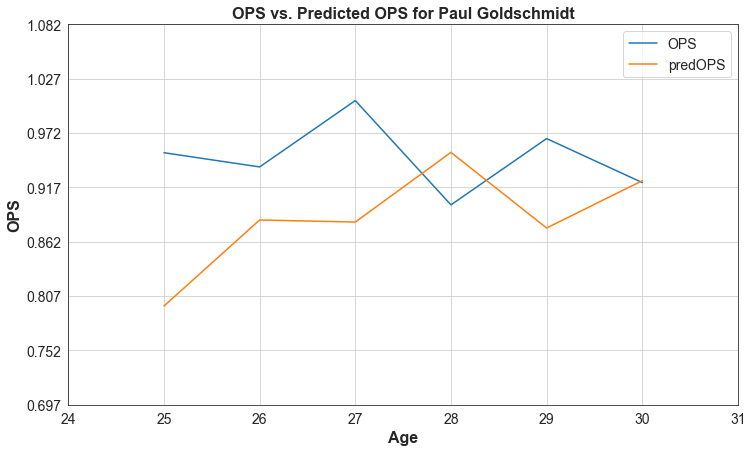

Player Name: Matt Holliday
Avg Actual OPS 0.887
Avg Predicted OPS 0.858
Pct Error 3.2


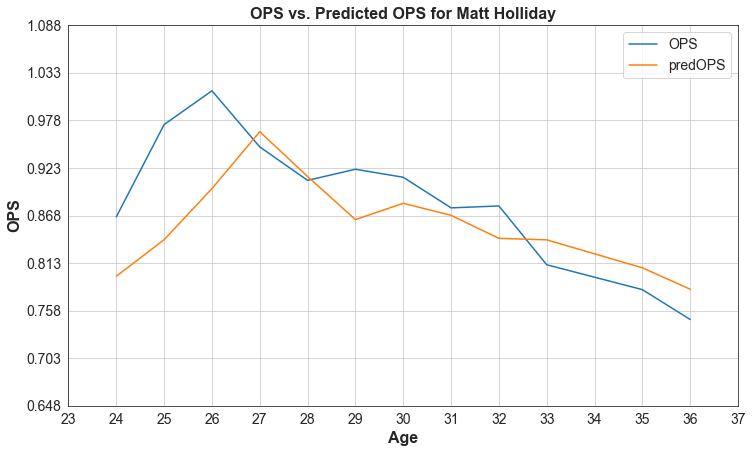

Player Name: Willie McGee
Avg Actual OPS 0.743
Avg Predicted OPS 0.738
Pct Error 0.7


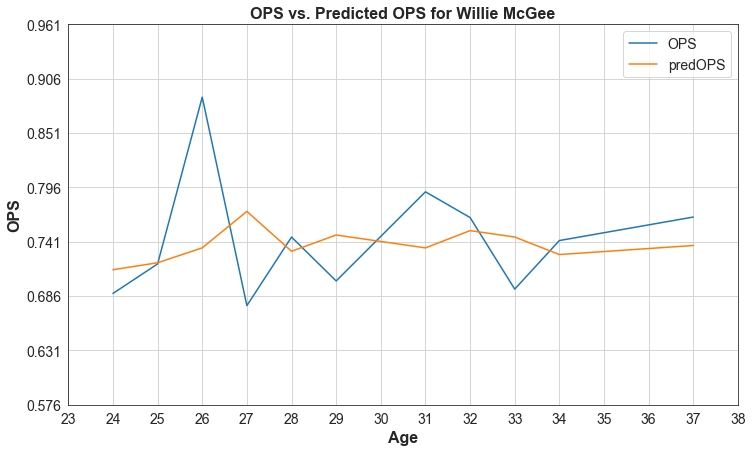

Player Name: Yadier Molina
Avg Actual OPS 0.743
Avg Predicted OPS 0.715
Pct Error 3.7


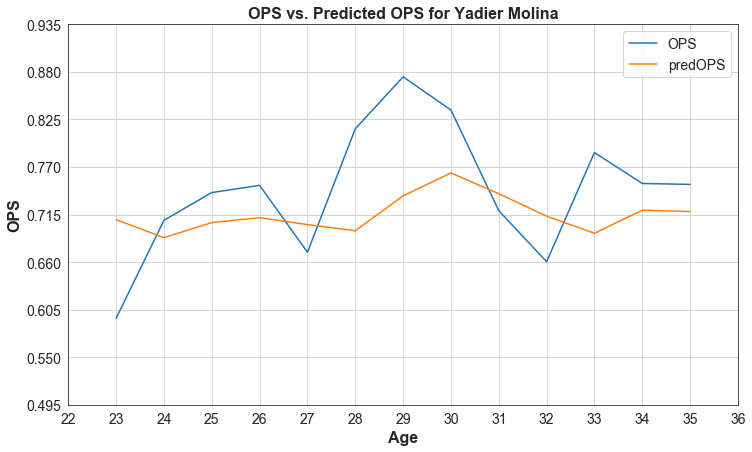

Player Name: Paul Molitor
Avg Actual OPS 0.841
Avg Predicted OPS 0.787
Pct Error 6.4


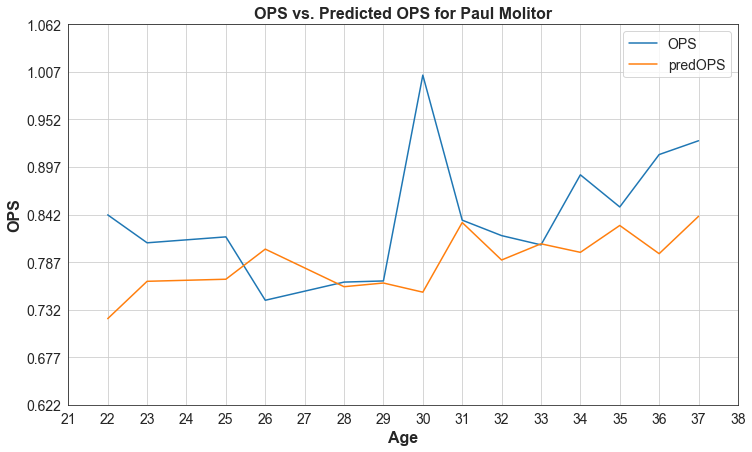

Player Name: Scott Rolen
Avg Actual OPS 0.872
Avg Predicted OPS 0.857
Pct Error 1.7


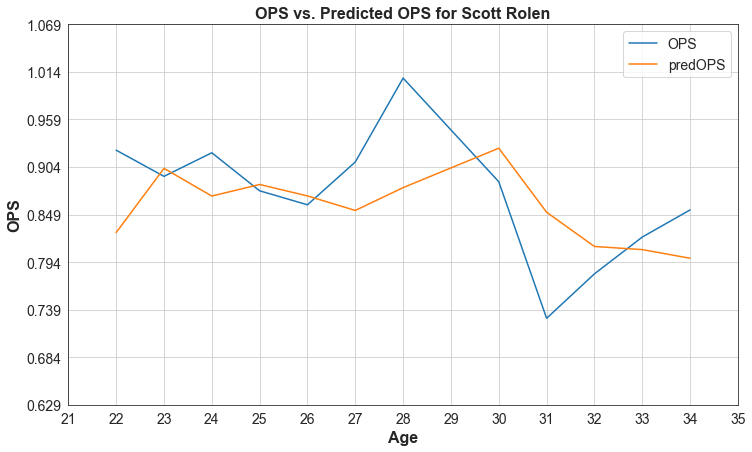

Player Name: Ron Santo
Avg Actual OPS 0.825
Avg Predicted OPS 0.807
Pct Error 2.2


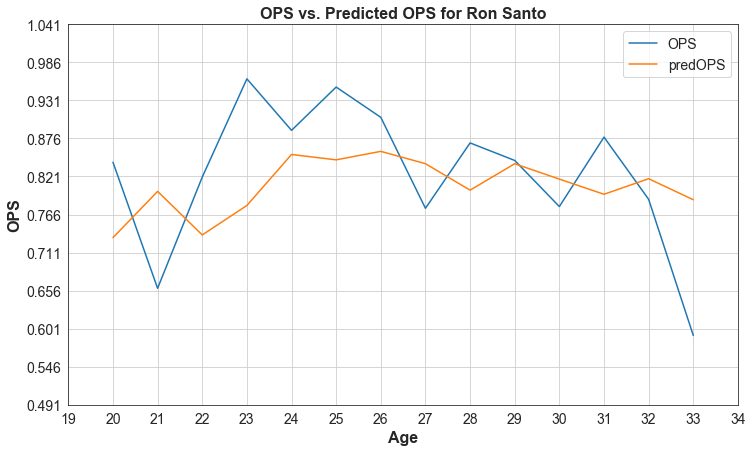

Player Name: Ichiro Suzuki
Avg Actual OPS 0.786
Avg Predicted OPS 0.786
Pct Error 0.0


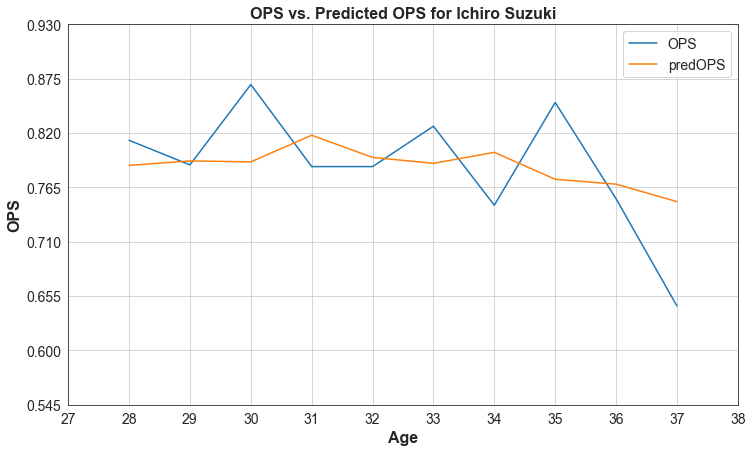

Player Name: Billy Williams
Avg Actual OPS 0.850
Avg Predicted OPS 0.828
Pct Error 2.5


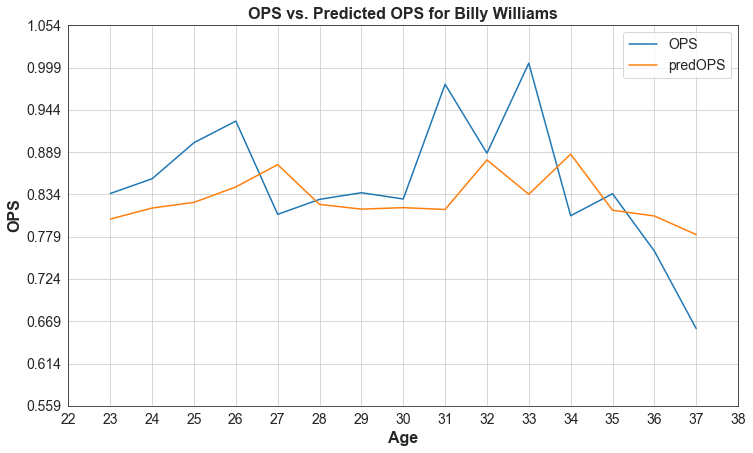

In [7]:
#
#  plots some of my favorite players.  Cards fan was a Cubs fan...so had to included both
#

figsize(12,7)
path = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\core\\'
filen = 'OPSpredictionsXGB_GS_select.csv'
selectf = path + filen
dfs = pd.read_csv(selectf)
playerlst = ['goldspa01','willibi01','santoro01','molitpa01','claytro01','molinya01','suzukic01','mcgeewi01','brocklo01','rolensc01','hollima01']
dfsc = dfs[dfs['playerID'].isin(playerlst)]
plrlst = dfsc.playerID.drop_duplicates()
for p in plrlst:
    dfsp = dfs[dfs['playerID'] == p].sort_values('age')
    dfsp = dfsp.reset_index(drop=True)
    OPSlst = dfsp.OPS
    predOPSlst = dfsp.predOPS
    combOPS = OPSlst.append(predOPSlst)
    minOPS = round(min(combOPS),3)
    maxOPS = round(max(combOPS),3)
    agelst = dfsp.age
    minage = min(agelst)
    maxage = max(agelst)
    x = OPSlst.mean()
    y = predOPSlst.mean()
    z = ((x-y)/x ) * 100
    pname = dfsp.playername.drop_duplicates()[0]
    print('Player Name: ' + pname)
    print('Avg Actual OPS %1.3f' % x)
    print('Avg Predicted OPS %1.3f' % y)
    print('Pct Error %1.1f' % z)
    ttl = 'OPS vs. Predicted OPS for ' + pname
    fig, ax = plt.subplots()
    ax.grid()
    plt.title(ttl,weight='bold',size=16)
    plt.xlabel('Age',weight='bold',size=16)
    plt.ylabel('OPS',weight='bold',size=16)
    plt.plot(agelst, OPSlst)
    plt.plot(agelst, predOPSlst)
    plt.yticks(np.arange(minOPS-.1,maxOPS+.1,.055))
    plt.xticks(np.arange(minage-1,maxage+2,1))
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
    leg = plt.legend(prop=dict(size=14))
    plt.show()